In [7]:
import pandas as pd
import matplotlib.pyplot as plt

from code.reductions import CNN_GCNN, EENTh, DROP

# from code.knn import callKNN
# from code.svm import callSVM

In [8]:
def load_ds(name, num_folds=10):

    folds_data = []

    for fold in range(num_folds):

        train_file = f'{name}_csv/{name}.fold.00000{fold}.train.csv'

        df_train = pd.read_csv(train_file)

        X_train = df_train.iloc[:, :-1]
        y_train = df_train.iloc[:, -1]

        folds_data.append((X_train, y_train,))

    return folds_data     

def load_ds_train_reductions(name, method, num_folds=10):

    folds_data = []

    for fold in range(num_folds):

        train_file = f'{name}_csv/{name}.fold.00000{fold}_{method}.train.csv'
        test_file = f'{name}_csv/{name}.fold.00000{fold}.test.csv'

        df_train = pd.read_csv(train_file)
        df_test = pd.read_csv(test_file)

        X_train = df_train.iloc[:, :-1]
        y_train = df_train.iloc[:, -1]
        X_test = df_test.iloc[:, :-1]
        y_test = df_test.iloc[:, -1]

        folds_data.append((X_train, X_test, y_train, y_test))

    return folds_data   

In [9]:
def store_ds(name, fold, method, prototypes_X, prototypes_y, X_train, y_train):
    X_train = pd.DataFrame(prototypes_X, columns = X_train.columns)
    y_train = pd.Series(prototypes_y, name = y_train.name, dtype=int)
    df = pd.concat((X_train, y_train), axis=1)
    df.to_csv(f'{name}_csv/{name}.fold.00000{fold}_{method}.train.csv', index=False)

In [23]:
def plot_grid(X_train, y_train, ax, title):
    ax.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='blue', label='Class 0')
    ax.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='red', label='Class 1')
    #ax.set_xlim([0, 1])
    #ax.set_ylim([0, 1])
    ax.set_title(title)
    ax.legend()


In [27]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
class DROP:
    def __init__(self, drop_type='drop1', k=3):
        self.k = k
        self.drop_type = drop_type

    def classify_without(self, idx, exclude_idx):
        filtered_indices = [i for i in self.neighbors[idx] if i != exclude_idx][:self.k]
        return np.argmax(np.bincount(self.y[filtered_indices]))

    def fit(self, X, y):
        self.X = X
        self.y = y.astype(int)
        self.original_indices = list(range(len(X)))

        # Initialize neighbors and associates for each instance
        self.nbrs = KNeighborsClassifier(n_neighbors=self.k + 2).fit(X, y)
        
        # Initialize S with all indices
        S = list(range(len(X)))

        self.neighbors = {i: list(self.nbrs.kneighbors([X[i]], return_distance=False)[0][1:]) for i in S}
        
        # Noise filtering pass for DROP3
        if self.drop_type == 'drop3':
            S = self.noise_filtering_pass(S)

        # Create enemy distance list if using DROP2 or DROP3
        if self.drop_type in ['drop2', 'drop3']:
            distances_to_enemies = {
                i: np.min([np.linalg.norm(X[i] - X[j]) for j in S if y[i] != y[j]])
                for i in S
            }
            S = sorted(S, key=lambda x: distances_to_enemies[x], reverse=True)
        
        self.nbrs = KNeighborsClassifier(n_neighbors=self.k + 2).fit(X[S], y[S])


        # Initialize associates for each instance in S
        associates = {i: set() for i in S}
        for p, ns in self.neighbors.items():
            for n in ns:
                if n in associates:
                    associates[n].add(p)

        # Evaluate each instance in the order of S
        for p in S[:]:  # Iterate over a copy of S to avoid modification during iteration

            with_correct = sum(1 for a in associates[p] if self.classify_without(a, None) == self.y[a])
            without_correct = sum(1 for a in associates[p] if self.classify_without(a, p) == self.y[a])

            # Remove P if classification accuracy does not degrade
            if without_correct >= with_correct:
                S.remove(p)
                
                # Update neighbors and associates after removing p
                for a in list(associates[p]):

                    self.neighbors[a].remove(p)
                    # Get the original index of 'a'
                    original_a_index = a
                    
                    # Get the subset of indices for S
                    S_indices = np.array(S)  # Get the indices of the current subset
                    S_data = self.X[S]  # Subset data using S indices
                    distances = np.linalg.norm(S_data - self.X[original_a_index], axis=1)  # Calculate distance to all instances in X[S]
                    sorted_indices = np.argsort(distances)  # Sort distances to get indices of neighbors

                    new_neighbor = [S_indices[idx] for idx in sorted_indices if S_indices[idx] != original_a_index and S_indices[idx] != p and S_indices[idx] not in self.neighbors[a]]
                    if new_neighbor:
                        self.neighbors[a].append(new_neighbor[0])
                        associates[new_neighbor[0]].add(a)
                
                if self.drop_type == 'drop1':
                    for neighbor in self.neighbors[p]:
                        if p in associates[neighbor]:
                            associates[neighbor].remove(p)
                    
                    associates[p].clear()

        X_prototypes = self.X[S]
        y_prototypes = self.y[S]
        return X_prototypes, y_prototypes

    def noise_filtering_pass(self, S):
        for p in S[:]:
            if self.classify_without(p, None) != self.y[p]:
                S.remove(p)
        return S

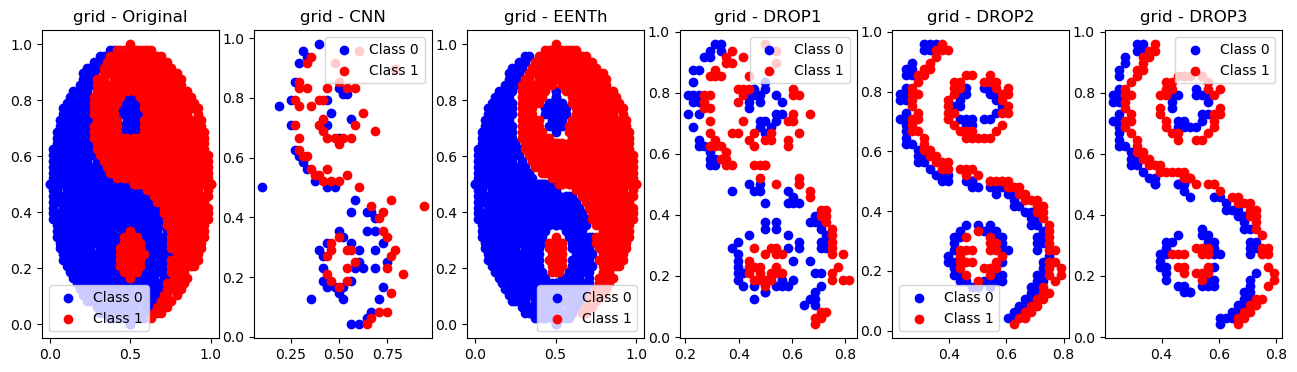

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(16, 4))
datasets = ['grid'] #'grid'
titles = ['Original', 'CNN', 'EENTh', 'DROP1', 'DROP2', 'DROP3']

# Loop through datasets and apply different methods
for ds in datasets:
    for i, (X_train, y_train) in enumerate(load_ds(ds)):

        # Original dataset plot
        if ds == 'grid' and i == 0:
            plot_grid(X_train.values, y_train.values, ax[0], f'{ds} - {titles[0]}')

        # CNN
        cnn = CNN_GCNN(rho=0)
        prototypes_X, prototypes_y = cnn.fit(X_train.values, y_train.values)
        if ds == 'grid' and i == 0:
            plot_grid(prototypes_X, prototypes_y, ax[1], f'{ds} - {titles[1]}')
        store_ds(ds, i, 'CNN', prototypes_X, prototypes_y, X_train, y_train)

        # EENTh
        eetnh = EENTh(k=3, threshold=0.99)
        prototypes_X, prototypes_y = eetnh.fit(X_train.values, y_train.values)
        if ds == 'grid' and i == 0:
            plot_grid(prototypes_X, prototypes_y, ax[2], f'{ds} - {titles[2]}')
        store_ds(ds, i, 'EENTh', prototypes_X, prototypes_y, X_train, y_train)

        # DROP
        drop = DROP(drop_type='drop1', k=7)
        prototypes_X, prototypes_y = drop.fit(X_train.values, y_train.values)
        if ds == 'grid' and i == 0:
            plot_grid(prototypes_X, prototypes_y, ax[3], f'{ds} - {titles[3]}')
        store_ds(ds, i, 'DROP', prototypes_X, prototypes_y, X_train, y_train)

        drop = DROP(drop_type='drop2', k=7)
        prototypes_X, prototypes_y = drop.fit(X_train.values, y_train.values)
        if ds == 'grid' and i == 0:
            plot_grid(prototypes_X, prototypes_y, ax[4], f'{ds} - {titles[4]}')
        store_ds(ds, i, 'DROP', prototypes_X, prototypes_y, X_train, y_train)

        drop = DROP(drop_type='drop3', k=7)
        prototypes_X, prototypes_y = drop.fit(X_train.values, y_train.values)
        if ds == 'grid' and i == 0:
            plot_grid(prototypes_X, prototypes_y, ax[5], f'{ds} - {titles[5]}')
        store_ds(ds, i, 'DROP', prototypes_X, prototypes_y, X_train, y_train)

        break
    break
    

In [14]:
dataset_names = ['sick', 'grid']
methods = ['svm', 'knn']
best_params = {'grid': {
                    'knn': {
                        'K': 7,
                        'Distance': 'minkowski2',
                        'Voting scheme': 'Majority_class',
                        'Weight scheme': 'Mutual_classifier'},
                    'svm': 
                        {'Kernel': 'rbf'}}, 
                'sick': {
                    'knn':{
                        'K': 7, 
                        'Distance': 'HEOM', 
                        'Voting scheme': 'Majority_class', 
                        'Weight scheme': 'Mutual_classifier'},
                    'svm': 
                        {'Kernel': 'rbf'}}}

for ds_name in dataset_names:
    for method in methods:
        for reduction in ['CNN', 'DROP', 'EENTh']:
            for i, (X_train, X_test, y_train, y_test) in enumerate(load_ds_train_reductions(ds_name, reduction)):
                print(i, reduction)
                if method == 'knn':
                    results = callKNN(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,  
                                    dist_func=best_params[ds_name][method]['Distance'], 
                                    voting_scheme=best_params[ds_name][method]['Voting scheme'], 
                                    weight_scheme=best_params[ds_name][method]['Weight scheme'], 
                                    k=best_params[ds_name][method]['K'])    
                elif method == 'svm':
                    results = callSVM(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                                    kernel=best_params[ds_name][method]['Kernel'])
                results.to_csv(f'results_{method}_reduced/results_{ds_name}_{i}_{reduction}.csv', index=False)

0 CNN
1 CNN
2 CNN


c:\Users\xavid\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xavid\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3 CNN
4 CNN
5 CNN


c:\Users\xavid\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xavid\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6 CNN
7 CNN
8 CNN


c:\Users\xavid\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9 CNN
0 DROP


ValueError: The number of classes has to be greater than one; got 1 class